- **News Headlines** (Sarcasm Headlines Dataset)
- **Tweets** (Tweets with Sarcasm and Irony)

In [1]:
# 1. Dependencies & Imports
!pip install transformers torch torchvision torchaudio nltk scikit-learn pandas matplotlib seaborn tqdm

import os
import json
import re
import multiprocessing as mp
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
environment = os.getenv('CUDA_VISIBLE_DEVICES')
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from tqdm.auto import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
# 2. Dataset Loading & Multiprocessing Preprocessing
# File paths
HEADLINES_PATH = 'Sarcasm_Headlines_Dataset.json'
TWEETS_TRAIN   = 'train.csv'
TWEETS_TEST    = 'test.csv'

In [6]:
# Text cleaning (remove punctuation, lowercasing, lemmatization, remove emojis entirely)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text, stop_words, lemmatizer):
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"[\.,!?;:\"'()\[\]{}#]", '', text)
    # text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in stop_words]
    return " ".join(tokens)

In [7]:
# 3. Loading & Cleaning Functions

from functools import partial
import pandas as pd
import json
import multiprocessing as mp

def load_and_clean_json(path, clean_fn, stop_words, lemmatizer, n_workers=None):
    """
    Loads the Sarcasm Headlines JSON dataset and cleans the 'headline' field.
    Returns a DataFrame with columns ['headline', 'is_sarcastic', 'clean_text'].
    """
    # read in all lines and parse JSON
    with open(path, 'r') as f:
        records = [json.loads(line) for line in f]
    df = pd.DataFrame(records)[['headline', 'is_sarcastic']]

    # set up pool
    n_workers = n_workers or mp.cpu_count()
    with mp.Pool(n_workers) as pool:
        clean = partial(clean_fn, stop_words=stop_words, lemmatizer=lemmatizer)
        df['clean_text'] = pool.map(clean, df['headline'].tolist())
    return df

def load_and_clean_csv(path, text_col, label_col, clean_fn, stop_words, lemmatizer, n_workers=None):
    """
    Loads a CSV (train or test), expecting at least `text_col` and `label_col`.
    Returns a DataFrame with columns [text_col, label_col, 'clean_text'].
    """
    df = pd.read_csv(path)
    if text_col not in df.columns or label_col not in df.columns:
        raise ValueError(f"CSV must contain '{text_col}' and '{label_col}' columns")

    # parallel clean
    n_workers = n_workers or mp.cpu_count()
    with mp.Pool(n_workers) as pool:
        clean = partial(clean_fn, stop_words=stop_words, lemmatizer=lemmatizer)
        df['clean_text'] = pool.map(clean, df[text_col].astype(str).tolist())
    return df

In [8]:
# 4. Execute loading + cleaning

# Headlines
sarcasm_df = load_and_clean_json(
    HEADLINES_PATH,
    clean_text,
    stop_words,
    lemmatizer,
    n_workers=4  # omit to use all cores
)

In [9]:
# Filter out rows where 'clean_text' is empty
sarcasm_df = sarcasm_df[sarcasm_df['clean_text'].str.len() > 0].reset_index(drop=True)
print(f"Headlines after filtering empty texts: {sarcasm_df.shape}")

Headlines after filtering empty texts: (26708, 3)


In [10]:
# Tweets train / test
tweets_train_df = load_and_clean_csv(
    TWEETS_TRAIN,
    text_col='tweets',
    label_col='class',
    clean_fn=clean_text,
    stop_words=stop_words,
    lemmatizer=lemmatizer,
    n_workers=4
)

tweets_test_df = load_and_clean_csv(
    TWEETS_TEST,
    text_col='tweets',
    label_col='class',
    clean_fn=clean_text,
    stop_words=stop_words,
    lemmatizer=lemmatizer,
    n_workers=4
)

In [11]:
# Filter out rows where 'clean_text' is empty
tweets_train_df = tweets_train_df[tweets_train_df['clean_text'].str.len() > 0].reset_index(drop=True)
print(f"Train tweets after filtering empty texts: {tweets_train_df.shape}")

Train tweets after filtering empty texts: (81404, 3)


In [12]:
# Filter out rows where 'clean_text' is empty
tweets_test_df = tweets_test_df[tweets_test_df['clean_text'].str.len() > 0].reset_index(drop=True)
print(f"Test tweets after filtering empty texts: {tweets_test_df.shape}")

Test tweets after filtering empty texts: (8128, 3)


In [13]:
# 5. Quick check
print("Headlines:", sarcasm_df.shape)
print(sarcasm_df.head())
print("Train tweets:", tweets_train_df.shape)
print(tweets_train_df.head())
print("Test tweets:", tweets_test_df.shape)
print(tweets_test_df.head())

Headlines: (26708, 3)
                                            headline  is_sarcastic  \
0  former versace store clerk sues over secret 'b...             0   
1  the 'roseanne' revival catches up to our thorn...             0   
2  mom starting to fear son's web series closest ...             1   
3  boehner just wants wife to listen, not come up...             1   
4  j.k. rowling wishes snape happy birthday in th...             0   

                                          clean_text  
0  former versace store clerk sue secret black co...  
1  roseanne revival catch thorny political mood b...  
2  mom starting fear son web series closest thing...  
3  boehner want wife listen come alternative debt...  
4   jk rowling wish snape happy birthday magical way  
Train tweets: (81404, 3)
                                              tweets       class  \
0  Be aware  dirty step to get money  #staylight ...  figurative   
1  #sarcasm for #people who don't understand #diy...  figurative  

EDA

In [14]:
# Dataset sizes & class balance
datasets = {
    'Headlines':   (sarcasm_df,   'is_sarcastic'),
    'Train Tweets':(tweets_train_df,'class'),
    'Test Tweets': (tweets_test_df, 'class'),
}

for name, (df, label_col) in datasets.items():
    print(f"\n=== {name} ===")
    print(f"Total samples: {len(df)}")
    print("Label distribution:")
    print(df[label_col].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')



=== Headlines ===
Total samples: 26708
Label distribution:
is_sarcastic
0    56.1%
1    43.9%
Name: proportion, dtype: object

=== Train Tweets ===
Total samples: 81404
Label distribution:
class
figurative    26.09%
irony         25.66%
sarcasm        25.4%
regular       22.84%
Name: proportion, dtype: object

=== Test Tweets ===
Total samples: 8128
Label distribution:
class
irony          26.0%
sarcasm       25.93%
figurative    25.18%
regular        22.9%
Name: proportion, dtype: object



Headlines text length (tokens):
count    26708.00
mean         7.13
std          2.28
min          1.00
25%          6.00
50%          7.00
75%          9.00
max         27.00
Name: clean_text, dtype: float64


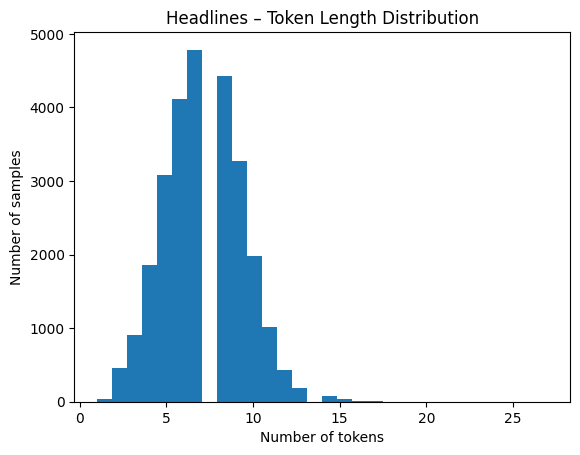


Train Tweets text length (tokens):
count    81404.00
mean         9.76
std          3.37
min          1.00
25%          7.00
50%         10.00
75%         12.00
max         27.00
Name: clean_text, dtype: float64


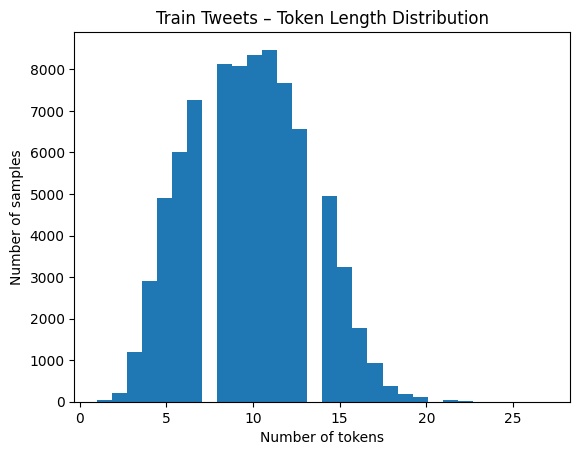


Test Tweets text length (tokens):
count    8128.00
mean        9.79
std         3.36
min         1.00
25%         7.00
50%        10.00
75%        12.00
max        24.00
Name: clean_text, dtype: float64


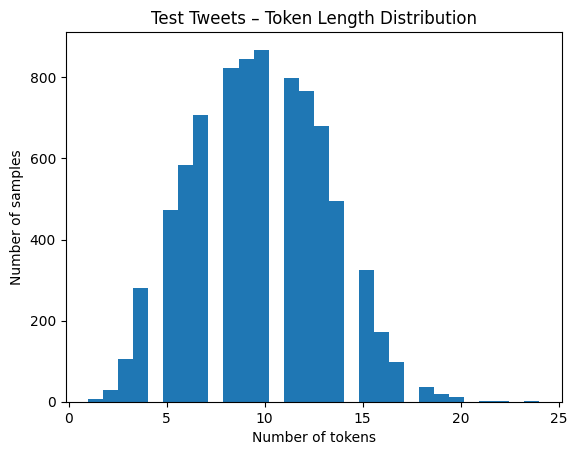

In [15]:
# 2. Text‐length stats & histograms
for name, (df, _) in datasets.items():
    lengths = df['clean_text'].str.split().apply(len)
    print(f"\n{name} text length (tokens):")
    print(lengths.describe().round(2))

    plt.figure()
    plt.hist(lengths, bins=30)
    plt.title(f'{name} – Token Length Distribution')
    plt.xlabel('Number of tokens')
    plt.ylabel('Number of samples')
    plt.show()

In [16]:
# 3. Top‐N tokens
def top_n_tokens(series, N=20):
    ctr = Counter()
    for text in series:
        ctr.update(text.split())
    return pd.DataFrame(ctr.most_common(N), columns=['token','count'])

for name, (df, _) in datasets.items():
    print(f"\nTop 20 tokens in {name}:")
    display(top_n_tokens(df['clean_text'], 20))


Top 20 tokens in Headlines:


,token,count
0,trump,1648
1,new,1516
2,man,1378
3,woman,803
4,say,663
5,report,593
6,get,585
7,u,568
8,one,535
9,day,519



Top 20 tokens in Train Tweets:


,token,count
0,sarcasm,29976
1,irony,24142
2,ironic,8236
3,news,3438
4,im,3414
5,love,3405
6,like,3401
7,-,3400
8,people,3287
9,get,3186



Top 20 tokens in Test Tweets:


,token,count
0,sarcasm,3006
1,irony,2412
2,ironic,822
3,love,381
4,im,362
5,-,357
6,news,349
7,&amp,328
8,get,326
9,peace,319


BERT MODEL

In [17]:
# Dataset wrapper
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        enc = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids':      enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'labels':         torch.tensor(label, dtype=torch.long)
        }

In [18]:
# Utility: create dataloaders
def make_loader(df, text_col, label_col, tokenizer, batch_size=16, shuffle=False):
    ds = TextDataset(
        texts=df[text_col].tolist(),
        labels=df[label_col].tolist(),
        tokenizer=tokenizer
    )
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

In [70]:
# Training + evaluation loop
def train_epoch(model, loader, optimizer, scheduler, device):
    model.train()
    losses = []
    preds, targets = [], []

    for batch in tqdm(loader, desc='Train'):
        input_ids = batch['input_ids'].to(device)
        attn_mask = batch['attention_mask'].to(device)
        labels    = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attn_mask, labels=labels)
        loss    = outputs.loss
        logits  = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        losses.append(loss.item())
        preds.extend(torch.argmax(logits, dim=1).cpu().tolist())
        targets.extend(labels.cpu().tolist())

    acc = accuracy_score(targets, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(targets, preds, average='binary')
    return np.mean(losses), acc, precision, recall, f1

def eval_model(model, loader, device):
    model.eval()
    losses = []
    preds, targets = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc='Eval '):
            input_ids = batch['input_ids'].to(device)
            attn_mask = batch['attention_mask'].to(device)
            labels    = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attn_mask, labels=labels)
            loss    = outputs.loss
            logits  = outputs.logits

            losses.append(loss.item())
            preds.extend(torch.argmax(logits, dim=1).cpu().tolist())
            targets.extend(labels.cpu().tolist())

    acc = accuracy_score(targets, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(targets, preds, average='binary')
    return np.mean(losses), acc, precision, recall, f1

In [72]:
# Hyperparameters & tokenizer/model
PRETRAINED = 'bert-base-uncased'
tokenizer  = BertTokenizer.from_pretrained(PRETRAINED)

def fine_tune(df_train, df_val, text_col, label_col, num_epochs=3, batch_size=16, lr=2e-5):
    # DataLoaders
    train_loader = make_loader(df_train, text_col, label_col, tokenizer, batch_size, shuffle=True)
    val_loader   = make_loader(df_val,   text_col, label_col, tokenizer, batch_size, shuffle=False)

    # Model
    model = BertForSequenceClassification.from_pretrained(PRETRAINED, num_labels=2)
    model.to(device)

    # Optimizer + scheduler
    optimizer = AdamW(model.parameters(), lr=lr)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps= int(0.1 * total_steps),
        num_training_steps= total_steps
    )

    # Training loop
    for epoch in range(num_epochs):
        print(f"\n=== Epoch {epoch+1}/{num_epochs} ===")
        train_loss, train_acc, train_p, train_r, train_f1 = train_epoch(model, train_loader, optimizer, scheduler, device)
        val_loss,   val_acc,   val_p,   val_r,   val_f1   = eval_model(model, val_loader,   device)

        print(f"Train → loss: {train_loss:.3f}, acc: {train_acc:.3f}, f1: {train_f1:.3f}")
        print(f"Val   → loss: {val_loss:.3f}, acc: {val_acc:.3f}, f1: {val_f1:.3f}")

    return model

In [21]:
# Split & run for each dataset

# Sarcasm Headlines
sh_train, sh_val = train_test_split(
    sarcasm_df,
    test_size=0.1,
    stratify=sarcasm_df['is_sarcastic'],
    random_state=42
)

print("Fine‐tuning on Headlines…")
bert_headlines = fine_tune(
    sh_train,
    sh_val,
    text_col='clean_text',
    label_col='is_sarcastic',
    num_epochs=3,
    batch_size=16,
    lr=2e-5
)

Fine‐tuning on Headlines…


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Epoch 1/3 ===


Train:   0%|          | 0/1503 [00:00<?, ?it/s]

Eval :   0%|          | 0/167 [00:00<?, ?it/s]

Train → loss: 0.431, acc: 0.796, f1: 0.756
Val   → loss: 0.319, acc: 0.859, f1: 0.841

=== Epoch 2/3 ===


Train:   0%|          | 0/1503 [00:00<?, ?it/s]

Eval :   0%|          | 0/167 [00:00<?, ?it/s]

Train → loss: 0.220, acc: 0.913, f1: 0.901
Val   → loss: 0.317, acc: 0.870, f1: 0.846

=== Epoch 3/3 ===


Train:   0%|          | 0/1503 [00:00<?, ?it/s]

Eval :   0%|          | 0/167 [00:00<?, ?it/s]

Train → loss: 0.089, acc: 0.968, f1: 0.964
Val   → loss: 0.387, acc: 0.875, f1: 0.856


LSTM

In [22]:
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

# Build vocabulary
def build_vocab(texts, min_freq=2):
    ctr = Counter()
    for t in texts:
        ctr.update(t.split())
    # reserve 0 for padding, 1 for OOV
    vocab = {'<pad>':0, '<oov>':1}
    for w, c in ctr.items():
        if c >= min_freq:
            vocab[w] = len(vocab)
    return vocab


In [23]:
# Dataset + collate fn
class TextLSTMDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.labels = labels
        self.vocab = vocab
        # convert tokens → indices
        self.seqs = []
        for t in texts:
            idxs = [vocab.get(tok, vocab['<oov>']) for tok in t.split()]
            self.seqs.append(torch.tensor(idxs, dtype=torch.long))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):
        return self.seqs[i], torch.tensor(self.labels[i], dtype=torch.long)

def lstm_collate(batch):
    seqs, labels = zip(*batch)
    seqs_padded = pad_sequence(seqs, batch_first=True, padding_value=0)
    lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
    labels = torch.stack(labels)
    return seqs_padded, lengths, labels

In [30]:
# Bi-LSTM model with dynamic output dim
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, n_classes, emb_dim=128, hidden_dim=128, n_layers=1, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=True, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim*2, n_classes)

    def forward(self, x, lengths):
        emb = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths.cpu(),
                                                   batch_first=True,
                                                   enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed)
        h_final = torch.cat([h_n[-2], h_n[-1]], dim=1)
        return self.fc(self.dropout(h_final))

In [25]:
# Training & evaluation loops
def train_epoch(model, loader, opt, criterion, device):
    model.train()
    total_loss, preds, targets = 0, [], []
    for seqs, lengths, labels in tqdm(loader, desc="Train"):
        seqs, lengths, labels = seqs.to(device), lengths.to(device), labels.to(device)
        logits = model(seqs, lengths)
        loss = criterion(logits, labels)
        opt.zero_grad(); loss.backward(); opt.step()

        total_loss += loss.item()
        preds += torch.argmax(logits, dim=1).cpu().tolist()
        targets += labels.cpu().tolist()
    acc = (torch.tensor(preds)==torch.tensor(targets)).float().mean().item()
    return total_loss/len(loader), acc

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, preds, targets = 0, [], []
    with torch.no_grad():
        for seqs, lengths, labels in tqdm(loader, desc="Eval "):
            seqs, lengths, labels = seqs.to(device), lengths.to(device), labels.to(device)
            logits = model(seqs, lengths)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            preds += torch.argmax(logits, dim=1).cpu().tolist()
            targets += labels.cpu().tolist()
    acc = (torch.tensor(preds)==torch.tensor(targets)).float().mean().item()
    return total_loss/len(loader), acc

In [31]:
# Prepare data + run for each dataset
def run_lstm(df, text_col, label_col, batch_size=32, epochs=5, lr=1e-3):
    # a) split & build label map
    train_df, val_df = train_test_split(
        df, test_size=0.1, stratify=df[label_col], random_state=42
    )
    unique_labels = sorted(train_df[label_col].unique())
    label_map = {lbl:idx for idx, lbl in enumerate(unique_labels)}
    n_classes = len(unique_labels)
    print(f"Detected classes: {label_map}")

    # b) convert labels
    y_train = [label_map[l] for l in train_df[label_col]]
    y_val   = [label_map[l] for l in val_df[label_col]]

    # c) vocab & datasets
    vocab = build_vocab(train_df[text_col])
    train_ds = TextLSTMDataset(train_df[text_col], y_train, vocab)
    val_ds   = TextLSTMDataset(val_df[text_col],   y_val,   vocab)
    train_ld = DataLoader(train_ds, batch_size, shuffle=True, collate_fn=lstm_collate)
    val_ld   = DataLoader(val_ds,   batch_size, shuffle=False, collate_fn=lstm_collate)

    # d) model, optimizer, loss
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BiLSTMClassifier(len(vocab), n_classes).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=lr)
    crit  = nn.CrossEntropyLoss()

    # e) training loop
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_epoch(model, train_ld, opt, crit, device)
        val_loss, val_acc = eval_epoch(model, val_ld, crit, device)
        print(f"Epoch {ep}/{epochs} → "
              f"T loss {tr_loss:.3f}, acc {tr_acc:.3f} | "
              f"V loss {val_loss:.3f}, acc {val_acc:.3f}")
    return model

In [32]:
# === Execute ===
print("### Sarcasm Headlines LSTM ###")
lstm_headlines = run_lstm(sarcasm_df, 'clean_text', 'is_sarcastic')

### Sarcasm Headlines LSTM ###
Detected classes: {np.int64(0): 0, np.int64(1): 1}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Train:   0%|          | 0/752 [00:00<?, ?it/s]

Eval :   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 1/5 → T loss 0.549, acc 0.707 | V loss 0.479, acc 0.767


Train:   0%|          | 0/752 [00:00<?, ?it/s]

Eval :   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 2/5 → T loss 0.359, acc 0.838 | V loss 0.440, acc 0.790


Train:   0%|          | 0/752 [00:00<?, ?it/s]

Eval :   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 3/5 → T loss 0.208, acc 0.917 | V loss 0.496, acc 0.796


Train:   0%|          | 0/752 [00:00<?, ?it/s]

Eval :   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 4/5 → T loss 0.092, acc 0.966 | V loss 0.615, acc 0.796


Train:   0%|          | 0/752 [00:00<?, ?it/s]

Eval :   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 5/5 → T loss 0.035, acc 0.989 | V loss 0.818, acc 0.791


In [33]:
print("\n### Tweets LSTM ###")
lstm_tweets = run_lstm(tweets_train_df, 'clean_text', 'class')


### Tweets LSTM ###
Detected classes: {'figurative': 0, 'irony': 1, 'regular': 2, 'sarcasm': 3}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Eval :   0%|          | 0/255 [00:00<?, ?it/s]

Epoch 1/5 → T loss 0.517, acc 0.727 | V loss 0.504, acc 0.738


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Eval :   0%|          | 0/255 [00:00<?, ?it/s]

Epoch 2/5 → T loss 0.491, acc 0.734 | V loss 0.515, acc 0.739


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Eval :   0%|          | 0/255 [00:00<?, ?it/s]

Epoch 3/5 → T loss 0.484, acc 0.733 | V loss 0.523, acc 0.736


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Eval :   0%|          | 0/255 [00:00<?, ?it/s]

Epoch 4/5 → T loss 0.469, acc 0.736 | V loss 0.592, acc 0.721


Train:   0%|          | 0/2290 [00:00<?, ?it/s]

Eval :   0%|          | 0/255 [00:00<?, ?it/s]

Epoch 5/5 → T loss 0.440, acc 0.749 | V loss 0.726, acc 0.672


**Cross‐evaluation for BERT**

In [49]:
# 0) Make sure we have a binary column in tweets:
tweets_train_df['binary_label'] = (tweets_train_df['class'] == 'sarcasm').astype(int)
tweets_test_df ['binary_label'] = (tweets_test_df ['class'] == 'sarcasm').astype(int)

In [50]:
# --- 1) A Dataset wrapper that takes a label_map ---
class LabelledTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, label_map, max_len=64):
        self.texts = texts
        self.labels = [label_map[l] for l in labels]
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        enc = self.tokenizer.encode_plus(
            str(self.texts[idx]),
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids':      enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'labels':         torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [51]:
# --- 2) Training & eval loops (multi‐class ready) ---
def train_epoch(model, loader, optimizer, scheduler):
    model.train()
    losses, preds, targets = [], [], []
    for batch in tqdm(loader, desc="Train"):
        input_ids = batch['input_ids'].to(device)
        attn_mask = batch['attention_mask'].to(device)
        labels    = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attn_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        losses.append(loss.item())
        preds.extend(logits.argmax(dim=1).cpu().tolist())
        targets.extend(labels.cpu().tolist())

    acc = accuracy_score(targets, preds)
    p, r, f1, _ = precision_recall_fscore_support(targets, preds, average='weighted')
    return np.mean(losses), acc, p, r, f1

def eval_epoch(model, loader):
    model.eval()
    losses, preds, targets = [], [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Eval "):
            input_ids = batch['input_ids'].to(device)
            attn_mask = batch['attention_mask'].to(device)
            labels    = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attn_mask, labels=labels)
            loss, logits = outputs.loss, outputs.logits

            losses.append(loss.item())
            preds.extend(logits.argmax(dim=1).cpu().tolist())
            targets.extend(labels.cpu().tolist())

    acc = accuracy_score(targets, preds)
    p, r, f1, _ = precision_recall_fscore_support(targets, preds, average='weighted')
    return np.mean(losses), acc, p, r, f1

In [52]:
# --- 3) Cross‐eval function ---
def cross_eval_bert(train_df, text_col_train, label_col_train,
                    eval_df,  text_col_eval,  label_col_eval,
                    pretrained='bert-base-uncased',
                    num_epochs=2,
                    batch_size=16,
                    lr=2e-5):
    # a) split train/val
    tr_df, val_df = train_test_split(
        train_df,
        test_size=0.1,
        stratify=train_df[label_col_train],
        random_state=42
    )

    # b) build label_map
    unique_labels = sorted(tr_df[label_col_train].unique())
    label_map     = {lbl:i for i, lbl in enumerate(unique_labels)}
    num_labels    = len(unique_labels)
    print("Label map:", label_map)

    # c) tokenizer & model
    tokenizer = BertTokenizer.from_pretrained(pretrained)
    model     = BertForSequenceClassification.from_pretrained(
                    pretrained, num_labels=num_labels
                ).to(device)

    # d) datasets & loaders
    train_ds = LabelledTextDataset(
        tr_df[text_col_train].tolist(),
        tr_df[label_col_train].tolist(),
        tokenizer,
        label_map
    )
    val_ds = LabelledTextDataset(
        val_df[text_col_train].tolist(),
        val_df[label_col_train].tolist(),
        tokenizer,
        label_map
    )
    # filter out any eval samples whose label isn't in our train set
    mask = eval_df[label_col_eval].isin(label_map)
    eval_filtered = eval_df[mask].reset_index(drop=True)
    eval_ds = LabelledTextDataset(
        eval_filtered[text_col_eval].tolist(),
        eval_filtered[label_col_eval].tolist(),
        tokenizer,
        label_map
    )

    train_ld = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_ld   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
    eval_ld  = DataLoader(eval_ds,  batch_size=batch_size, shuffle=False)

    # e) optimizer & scheduler
    optimizer = AdamW(model.parameters(), lr=lr)
    total_steps = len(train_ld) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )

    # f) training loop
    for epoch in range(1, num_epochs+1):
        tr_loss, tr_acc, tr_p, tr_r, tr_f1 = train_epoch(model, train_ld, optimizer, scheduler)
        val_loss, val_acc, val_p, val_r, val_f1 = eval_epoch(model, val_ld)
        print(f"[Epoch {epoch}/{num_epochs}] "
              f"Train → loss: {tr_loss:.3f}, acc: {tr_acc:.3f}, f1: {tr_f1:.3f}")
        print(f"           Val   → loss: {val_loss:.3f}, acc: {val_acc:.3f}, f1: {val_f1:.3f}")

    # g) cross‐evaluation
    eval_loss, eval_acc, eval_p, eval_r, eval_f1 = eval_epoch(model, eval_ld)
    print(f"[Cross‐Eval] loss: {eval_loss:.3f}, acc: {eval_acc:.3f}, f1: {eval_f1:.3f}")
    return model

In [53]:
# Headlines → Tweets
bert_h2t = cross_eval_bert(
    sarcasm_df,       'clean_text', 'is_sarcastic',   # train on headline sarcasm 0/1
    tweets_test_df,   'clean_text', 'binary_label',   # eval on tweet sarcasm 0/1
    num_epochs=2
)

# Tweets → Headlines
bert_t2h = cross_eval_bert(
    tweets_train_df,   'clean_text', 'binary_label',   # train on tweet sarcasm 0/1
    sarcasm_df,        'clean_text', 'is_sarcastic',  # eval on headline sarcasm 0/1
    num_epochs=2
)

Label map: {np.int64(0): 0, np.int64(1): 1}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train:   0%|          | 0/1503 [00:00<?, ?it/s]

Eval :   0%|          | 0/167 [00:00<?, ?it/s]

[Epoch 1/2] Train → loss: 0.440, acc: 0.789, f1: 0.787
           Val   → loss: 0.331, acc: 0.852, f1: 0.851


Train:   0%|          | 0/1503 [00:00<?, ?it/s]

Eval :   0%|          | 0/167 [00:00<?, ?it/s]

[Epoch 2/2] Train → loss: 0.220, acc: 0.912, f1: 0.911
           Val   → loss: 0.326, acc: 0.866, f1: 0.865


Eval :   0%|          | 0/508 [00:00<?, ?it/s]

[Cross‐Eval] loss: 1.125, acc: 0.644, f1: 0.629
Label map: {np.int64(0): 0, np.int64(1): 1}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train:   0%|          | 0/4579 [00:00<?, ?it/s]

Eval :   0%|          | 0/509 [00:00<?, ?it/s]

[Epoch 1/2] Train → loss: 0.263, acc: 0.864, f1: 0.871
           Val   → loss: 0.247, acc: 0.870, f1: 0.877


Train:   0%|          | 0/4579 [00:00<?, ?it/s]

Eval :   0%|          | 0/509 [00:00<?, ?it/s]

[Epoch 2/2] Train → loss: 0.247, acc: 0.869, f1: 0.876
           Val   → loss: 0.247, acc: 0.870, f1: 0.877


Eval :   0%|          | 0/1670 [00:00<?, ?it/s]

[Cross‐Eval] loss: 4.113, acc: 0.561, f1: 0.404


**Cross‐evaluation for Bi-LSTM**

In [54]:
# 1) Vocabulary builder (unchanged)
def build_vocab(texts, min_freq=2):
    ctr = Counter()
    for t in texts:
        ctr.update(t.split())
    vocab = {'<pad>':0, '<oov>':1}
    for w, c in ctr.items():
        if c >= min_freq:
            vocab[w] = len(vocab)
    return vocab

In [55]:
# 2) Dataset + collate fn (unchanged)
class TextLSTMDataset(torch.utils.data.Dataset):
    def __init__(self, texts, label_idxs, vocab):
        self.seqs = [
            torch.tensor([vocab.get(tok, vocab['<oov>']) for tok in t.split()], dtype=torch.long)
            for t in texts
        ]
        self.labels = torch.tensor(label_idxs, dtype=torch.long)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, i):
        return self.seqs[i], self.labels[i]

def lstm_collate(batch):
    seqs, labels = zip(*batch)
    seqs_padded = pad_sequence(seqs, batch_first=True, padding_value=0)
    lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
    labels = torch.stack(labels)
    return seqs_padded, lengths, labels

In [56]:
# 3) Bi-LSTM classifier (unchanged)
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, n_classes, emb_dim=128, hidden_dim=128, n_layers=1, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=True, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim*2, n_classes)
    def forward(self, x, lengths):
        emb = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths.cpu(),
                                                   batch_first=True,
                                                   enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed)
        h_final = torch.cat([h_n[-2], h_n[-1]], dim=1)
        return self.fc(self.dropout(h_final))

In [57]:
# 4) Training & evaluation loops (unchanged)
def train_epoch_lstm(model, loader, opt, criterion, device):
    model.train()
    total_loss, preds, targets = 0, [], []
    for seqs, lengths, labels in tqdm(loader, desc="LSTM Train"):
        seqs, lengths, labels = seqs.to(device), lengths.to(device), labels.to(device)
        logits = model(seqs, lengths)
        loss = criterion(logits, labels)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item()
        preds.extend(logits.argmax(dim=1).cpu().tolist())
        targets.extend(labels.cpu().tolist())
    acc = (torch.tensor(preds)==torch.tensor(targets)).float().mean().item()
    return total_loss/len(loader), acc

def eval_epoch_lstm(model, loader, criterion, device):
    model.eval()
    total_loss, preds, targets = 0, [], []
    with torch.no_grad():
        for seqs, lengths, labels in tqdm(loader, desc="LSTM Eval"):
            seqs, lengths, labels = seqs.to(device), lengths.to(device), labels.to(device)
            logits = model(seqs, lengths)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            preds.extend(logits.argmax(dim=1).cpu().tolist())
            targets.extend(labels.cpu().tolist())
    acc = (torch.tensor(preds)==torch.tensor(targets)).float().mean().item()
    return total_loss/len(loader), acc

In [58]:
# 5) cross‐evaluation function
def cross_eval_lstm(df_train, text_col_train, label_col_train,
                    df_eval,  text_col_eval,  label_col_eval,
                    batch_size=32, epochs=5, lr=1e-3):
    # a) train/val split & label_map
    tr_df, val_df = train_test_split(
        df_train,
        test_size=0.1,
        stratify=df_train[label_col_train],
        random_state=42
    )
    unique_labels = sorted(tr_df[label_col_train].unique())
    label_map = {lbl: i for i, lbl in enumerate(unique_labels)}
    n_classes = len(unique_labels)
    print("[LSTM] label_map:", label_map)

    # b) vocab on train
    vocab = build_vocab(tr_df[text_col_train])

    # c) build loaders for train & val
    def make_loader(df, text_col, label_col, shuffle):
        # convert labels via map; if dtype is int, assume they match label_map directly
        if df[label_col].dtype.kind in {'i','u','f'}:
            label_idxs = [int(l) for l in df[label_col]]
        else:
            label_idxs = [label_map[l] for l in df[label_col] if l in label_map]
        texts = df[df[label_col].isin(label_map)][text_col].tolist() \
                if df[label_col].dtype.kind not in {'i','u','f'} \
                else df[text_col].tolist()
        ds = TextLSTMDataset(texts, label_idxs, vocab)
        return DataLoader(ds, batch_size, shuffle=shuffle, collate_fn=lstm_collate)

    train_ld = make_loader(tr_df,  text_col_train, label_col_train, shuffle=True)
    val_ld   = make_loader(val_df,  text_col_train, label_col_train, shuffle=False)
    eval_ld  = make_loader(df_eval, text_col_eval, label_col_eval, shuffle=False)

    # d) model, optimizer, loss
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model  = BiLSTMClassifier(len(vocab), n_classes).to(device)
    opt    = torch.optim.Adam(model.parameters(), lr=lr)
    crit   = nn.CrossEntropyLoss()

    # e) training loop
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_epoch_lstm(model, train_ld, opt, crit, device)
        v_loss,  v_acc  = eval_epoch_lstm( model, val_ld,   crit, device)
        print(f"[Epoch {ep}/{epochs}] Train L={tr_loss:.3f} A={tr_acc:.3f} | Val L={v_loss:.3f} A={v_acc:.3f}")

    # f) cross‐eval
    e_loss, e_acc = eval_epoch_lstm(model, eval_ld, crit, device)
    print(f"[Cross‐Eval] loss={e_loss:.3f}, acc={e_acc:.3f}")

    return model

In [59]:
# 1) Headlines → Tweets
#    Train on the headline dataset’s 0/1 labels, evaluate on the tweet test set’s binary_label
lstm_h2t = cross_eval_lstm(
    df_train      = sarcasm_df,
    text_col_train = 'clean_text',
    label_col_train= 'is_sarcastic',

    df_eval       = tweets_test_df,
    text_col_eval  = 'clean_text',
    label_col_eval = 'binary_label',

    batch_size=32,
    epochs    = 5,
    lr        = 1e-3
)


[LSTM] label_map: {np.int64(0): 0, np.int64(1): 1}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


LSTM Train:   0%|          | 0/752 [00:00<?, ?it/s]

LSTM Eval:   0%|          | 0/84 [00:00<?, ?it/s]

[Epoch 1/5] Train L=0.553 A=0.705 | Val L=0.473 A=0.768


LSTM Train:   0%|          | 0/752 [00:00<?, ?it/s]

LSTM Eval:   0%|          | 0/84 [00:00<?, ?it/s]

[Epoch 2/5] Train L=0.360 A=0.840 | Val L=0.441 A=0.793


LSTM Train:   0%|          | 0/752 [00:00<?, ?it/s]

LSTM Eval:   0%|          | 0/84 [00:00<?, ?it/s]

[Epoch 3/5] Train L=0.210 A=0.916 | Val L=0.517 A=0.794


LSTM Train:   0%|          | 0/752 [00:00<?, ?it/s]

LSTM Eval:   0%|          | 0/84 [00:00<?, ?it/s]

[Epoch 4/5] Train L=0.093 A=0.967 | Val L=0.619 A=0.794


LSTM Train:   0%|          | 0/752 [00:00<?, ?it/s]

LSTM Eval:   0%|          | 0/84 [00:00<?, ?it/s]

[Epoch 5/5] Train L=0.038 A=0.987 | Val L=0.788 A=0.791


LSTM Eval:   0%|          | 0/254 [00:00<?, ?it/s]

[Cross‐Eval] loss=1.765, acc=0.548


In [60]:
# 2) Tweets → Headlines
#    Train on tweets binary_label, evaluate on headline is_sarcastic
lstm_t2h = cross_eval_lstm(
    df_train      = tweets_train_df,
    text_col_train = 'clean_text',
    label_col_train= 'binary_label',

    df_eval       = sarcasm_df,
    text_col_eval  = 'clean_text',
    label_col_eval = 'is_sarcastic',

    batch_size=32,
    epochs    = 5,
    lr        = 1e-3
)


[LSTM] label_map: {np.int64(0): 0, np.int64(1): 1}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


LSTM Train:   0%|          | 0/2290 [00:00<?, ?it/s]

LSTM Eval:   0%|          | 0/255 [00:00<?, ?it/s]

[Epoch 1/5] Train L=0.258 A=0.864 | Val L=0.251 A=0.867


LSTM Train:   0%|          | 0/2290 [00:00<?, ?it/s]

LSTM Eval:   0%|          | 0/255 [00:00<?, ?it/s]

[Epoch 2/5] Train L=0.246 A=0.868 | Val L=0.251 A=0.869


LSTM Train:   0%|          | 0/2290 [00:00<?, ?it/s]

LSTM Eval:   0%|          | 0/255 [00:00<?, ?it/s]

[Epoch 3/5] Train L=0.242 A=0.865 | Val L=0.260 A=0.868


LSTM Train:   0%|          | 0/2290 [00:00<?, ?it/s]

LSTM Eval:   0%|          | 0/255 [00:00<?, ?it/s]

[Epoch 4/5] Train L=0.230 A=0.870 | Val L=0.294 A=0.856


LSTM Train:   0%|          | 0/2290 [00:00<?, ?it/s]

LSTM Eval:   0%|          | 0/255 [00:00<?, ?it/s]

[Epoch 5/5] Train L=0.209 A=0.882 | Val L=0.363 A=0.824


LSTM Eval:   0%|          | 0/835 [00:00<?, ?it/s]

[Cross‐Eval] loss=2.916, acc=0.554


**Hyperparameter Tuning**

In [61]:
import itertools

# === 1) BERT hyperparameter tuning ===

class SimpleBertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        enc = self.tokenizer.encode_plus(
            str(self.texts[idx]), add_special_tokens=True,
            max_length=self.max_len, truncation=True, padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids':      enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0),
            'labels':         torch.tensor(self.labels[idx], dtype=torch.long),
        }

def tune_bert(df, text_col, label_col, param_grid, n_splits=1):
    # split train/val once
    tr, val = train_test_split(df, test_size=0.1,
                               stratify=df[label_col], random_state=42)
    best = {'f1': -1}
    tokenizer = BertTokenizer.from_pretrained(param_grid['pretrained'][0])
    for (lr, batch_size, epochs, max_len) in itertools.product(
            param_grid['lr'],
            param_grid['batch_size'],
            param_grid['epochs'],
            param_grid['max_len']
        ):
        model = BertForSequenceClassification.from_pretrained(
            param_grid['pretrained'][0], num_labels=len(df[label_col].unique())
        ).to(device)
        optimizer = AdamW(model.parameters(), lr=lr)
        total_steps = (len(tr)//batch_size)*epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(0.1*total_steps),
            num_training_steps=total_steps
        )

        # loaders
        def make_loader(sub_df, shuffle):
            ds = SimpleBertDataset(
                sub_df[text_col].tolist(),
                sub_df[label_col].tolist(),
                tokenizer,
                max_len
            )
            return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)
        train_ld = make_loader(tr, True)
        val_ld   = make_loader(val, False)

        # train
        for _ in range(epochs):
            model.train()
            for batch in tqdm(train_ld, desc=f"Train lr={lr} bs={batch_size}"):
                optimizer.zero_grad()
                out = model(
                    batch['input_ids'].to(device),
                    attention_mask=batch['attention_mask'].to(device),
                    labels=batch['labels'].to(device)
                )
                out.loss.backward()
                optimizer.step()
                scheduler.step()

        # eval
        model.eval()
        preds, targets = [], []
        with torch.no_grad():
            for batch in val_ld:
                out = model(
                    batch['input_ids'].to(device),
                    attention_mask=batch['attention_mask'].to(device)
                )
                logits = out.logits
                preds.extend(logits.argmax(dim=1).cpu().tolist())
                targets.extend(batch['labels'].tolist())
        acc = accuracy_score(targets, preds)
        _, _, f1, _ = precision_recall_fscore_support(targets, preds, average='binary')

        print(f"===> lr={lr}, bs={batch_size}, ep={epochs}, max_len={max_len} → f1={f1:.4f}")
        if f1 > best['f1']:
            best = dict(lr=lr, batch_size=batch_size, epochs=epochs,
                        max_len=max_len, f1=f1, acc=acc)

    print("Best BERT config:", best)
    return best

In [62]:
# parameter grid
bert_param_grid = {
    'pretrained': ['bert-base-uncased'],
    'lr':         [2e-5, 3e-5],
    'batch_size': [16, 32],
    'epochs':     [2, 3],
    'max_len':    [64, 128],
}

# run
best_bert = tune_bert(
    sarcasm_df, 'clean_text', 'is_sarcastic',
    bert_param_grid
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train lr=2e-05 bs=16:   0%|          | 0/1503 [00:00<?, ?it/s]

Train lr=2e-05 bs=16:   0%|          | 0/1503 [00:00<?, ?it/s]

✅ lr=2e-05, bs=16, ep=2, max_len=64 → f1=0.8488


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train lr=2e-05 bs=16:   0%|          | 0/1503 [00:00<?, ?it/s]

Train lr=2e-05 bs=16:   0%|          | 0/1503 [00:00<?, ?it/s]

✅ lr=2e-05, bs=16, ep=2, max_len=128 → f1=0.8500


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train lr=2e-05 bs=16:   0%|          | 0/1503 [00:00<?, ?it/s]

Train lr=2e-05 bs=16:   0%|          | 0/1503 [00:00<?, ?it/s]

Train lr=2e-05 bs=16:   0%|          | 0/1503 [00:00<?, ?it/s]

✅ lr=2e-05, bs=16, ep=3, max_len=64 → f1=0.8569


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train lr=2e-05 bs=16:   0%|          | 0/1503 [00:00<?, ?it/s]

Train lr=2e-05 bs=16:   0%|          | 0/1503 [00:00<?, ?it/s]

Train lr=2e-05 bs=16:   0%|          | 0/1503 [00:00<?, ?it/s]

✅ lr=2e-05, bs=16, ep=3, max_len=128 → f1=0.8522


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train lr=2e-05 bs=32:   0%|          | 0/752 [00:00<?, ?it/s]

Train lr=2e-05 bs=32:   0%|          | 0/752 [00:00<?, ?it/s]

✅ lr=2e-05, bs=32, ep=2, max_len=64 → f1=0.8456


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train lr=2e-05 bs=32:   0%|          | 0/752 [00:00<?, ?it/s]

Train lr=2e-05 bs=32:   0%|          | 0/752 [00:00<?, ?it/s]

✅ lr=2e-05, bs=32, ep=2, max_len=128 → f1=0.8432


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train lr=2e-05 bs=32:   0%|          | 0/752 [00:00<?, ?it/s]

Train lr=2e-05 bs=32:   0%|          | 0/752 [00:00<?, ?it/s]

Train lr=2e-05 bs=32:   0%|          | 0/752 [00:00<?, ?it/s]

✅ lr=2e-05, bs=32, ep=3, max_len=64 → f1=0.8476


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train lr=2e-05 bs=32:   0%|          | 0/752 [00:00<?, ?it/s]

Train lr=2e-05 bs=32:   0%|          | 0/752 [00:00<?, ?it/s]

Train lr=2e-05 bs=32:   0%|          | 0/752 [00:00<?, ?it/s]

✅ lr=2e-05, bs=32, ep=3, max_len=128 → f1=0.8502


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train lr=3e-05 bs=16:   0%|          | 0/1503 [00:00<?, ?it/s]

Train lr=3e-05 bs=16:   0%|          | 0/1503 [00:00<?, ?it/s]

✅ lr=3e-05, bs=16, ep=2, max_len=64 → f1=0.8519


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train lr=3e-05 bs=16:   0%|          | 0/1503 [00:00<?, ?it/s]

Train lr=3e-05 bs=16:   0%|          | 0/1503 [00:00<?, ?it/s]

✅ lr=3e-05, bs=16, ep=2, max_len=128 → f1=0.8489


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train lr=3e-05 bs=16:   0%|          | 0/1503 [00:00<?, ?it/s]

Train lr=3e-05 bs=16:   0%|          | 0/1503 [00:00<?, ?it/s]

Train lr=3e-05 bs=16:   0%|          | 0/1503 [00:00<?, ?it/s]

✅ lr=3e-05, bs=16, ep=3, max_len=64 → f1=0.8536


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train lr=3e-05 bs=16:   0%|          | 0/1503 [00:00<?, ?it/s]

Train lr=3e-05 bs=16:   0%|          | 0/1503 [00:00<?, ?it/s]

Train lr=3e-05 bs=16:   0%|          | 0/1503 [00:00<?, ?it/s]

✅ lr=3e-05, bs=16, ep=3, max_len=128 → f1=0.8573


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train lr=3e-05 bs=32:   0%|          | 0/752 [00:00<?, ?it/s]

Train lr=3e-05 bs=32:   0%|          | 0/752 [00:00<?, ?it/s]

✅ lr=3e-05, bs=32, ep=2, max_len=64 → f1=0.8479


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train lr=3e-05 bs=32:   0%|          | 0/752 [00:00<?, ?it/s]

Train lr=3e-05 bs=32:   0%|          | 0/752 [00:00<?, ?it/s]

✅ lr=3e-05, bs=32, ep=2, max_len=128 → f1=0.8539


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train lr=3e-05 bs=32:   0%|          | 0/752 [00:00<?, ?it/s]

Train lr=3e-05 bs=32:   0%|          | 0/752 [00:00<?, ?it/s]

Train lr=3e-05 bs=32:   0%|          | 0/752 [00:00<?, ?it/s]

✅ lr=3e-05, bs=32, ep=3, max_len=64 → f1=0.8560


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train lr=3e-05 bs=32:   0%|          | 0/752 [00:00<?, ?it/s]

Train lr=3e-05 bs=32:   0%|          | 0/752 [00:00<?, ?it/s]

Train lr=3e-05 bs=32:   0%|          | 0/752 [00:00<?, ?it/s]

✅ lr=3e-05, bs=32, ep=3, max_len=128 → f1=0.8537
Best BERT config: {'lr': 3e-05, 'batch_size': 16, 'epochs': 3, 'max_len': 128, 'f1': 0.8572668112798265, 'acc': 0.8768251591164358}


In [65]:
# === 2) Bi-LSTM hyperparameter tuning (fast version because tuning took too long on BERT model)===

def lstm_collate(batch):
    seqs, labels = zip(*batch)
    seqs_padded = pad_sequence(seqs, batch_first=True, padding_value=0)
    lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
    labels = torch.stack(labels)
    return seqs_padded, lengths, labels

# Smaller Bi-LSTM
class FastBiLSTM(nn.Module):
    def __init__(self, vocab_size, n_classes,
                 emb_dim=64, hidden_dim=64, n_layers=1, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim,
                            num_layers=n_layers,
                            bidirectional=True,
                            batch_first=True,
                            dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, n_classes)
    def forward(self, x, lengths):
        emb = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths.cpu(),
                                                   batch_first=True,
                                                   enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed)
        h_final = torch.cat([h_n[-2], h_n[-1]], dim=1)
        return self.fc(h_final)

# Fast training loop with AMP
def train_fast_lstm(model, loader, optimizer, criterion, scaler):
    model.train()
    total_loss, total_acc = 0.0, 0.0
    for seqs, lengths, labels in tqdm(loader, desc="Train"):
        seqs, lengths, labels = seqs.to(device), lengths.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            logits = model(seqs, lengths)
            loss   = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        total_acc  += (logits.argmax(1) == labels).float().mean().item()
    return total_loss/len(loader), total_acc/len(loader)

def eval_fast_lstm(model, loader, criterion):
    model.eval()
    total_loss, total_acc = 0.0, 0.0
    with torch.no_grad():
        for seqs, lengths, labels in tqdm(loader, desc="Eval "):
            seqs, lengths, labels = seqs.to(device), lengths.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                logits = model(seqs, lengths)
                loss   = criterion(logits, labels)
            total_loss += loss.item()
            total_acc  += (logits.argmax(1) == labels).float().mean().item()
    return total_loss/len(loader), total_acc/len(loader)

# Optimized fine-tune function
def fast_finetune_lstm(df, text_col, label_col,
                       batch_size=64, epochs=2, lr=1e-3):
    # a) split train/val
    tr, val = train_test_split(df, test_size=0.1,
                                stratify=df[label_col], random_state=42)

    # b) build vocab & datasets
    vocab = build_vocab(tr[text_col])
    y_tr  = tr[label_col].tolist()
    y_val = val[label_col].tolist()

    train_ds = TextLSTMDataset(tr[text_col].tolist(), y_tr, vocab)
    val_ds   = TextLSTMDataset(val[text_col].tolist(),   y_val, vocab)

    train_ld = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          collate_fn=lstm_collate,
                          num_workers=4, pin_memory=True)
    val_ld   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False,
                          collate_fn=lstm_collate,
                          num_workers=4, pin_memory=True)

    # c) model, optimizer, loss, amp scaler
    model   = FastBiLSTM(len(vocab), len(set(y_tr))).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scaler    = torch.cuda.amp.GradScaler()

    # d) training
    for epoch in range(1, epochs+1):
        tr_loss, tr_acc = train_fast_lstm(model, train_ld, optimizer, criterion, scaler)
        v_loss,  v_acc  = eval_fast_lstm( model, val_ld,   criterion)
        print(f"[Epoch {epoch}/{epochs}] "
              f"Train L={tr_loss:.3f} A={tr_acc:.3f} | Val L={v_loss:.3f} A={v_acc:.3f}")

    return model


In [66]:
fast_model = fast_finetune_lstm(
     sarcasm_df, 'clean_text', 'is_sarcastic',
     batch_size=64, epochs=2, lr=1e-3
 )

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
<ipython-input-65-1468770353e4>:88: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = torch.cuda.amp.GradScaler()


Train:   0%|          | 0/376 [00:00<?, ?it/s]

<ipython-input-65-1468770353e4>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Eval :   0%|          | 0/42 [00:00<?, ?it/s]

[Epoch 1/2] Train L=0.599 A=0.663 | Val L=0.545 A=0.715


<ipython-input-65-1468770353e4>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train:   0%|          | 0/376 [00:00<?, ?it/s]

Eval :   0%|          | 0/42 [00:00<?, ?it/s]

[Epoch 2/2] Train L=0.445 A=0.787 | Val L=0.481 A=0.761


**Saving Models**

In [75]:
import os
import pickle

# 1. Make directories
os.makedirs('models/bert', exist_ok=True)
os.makedirs('models/lstm', exist_ok=True)


# 2. Save BERT heads
bert_headlines.save_pretrained('models/bert/bert_headlines')
#bert_tweets   .save_pretrained('models/bert/bert_tweets')
bert_h2t      .save_pretrained('models/bert/bert_h2t')
bert_t2h      .save_pretrained('models/bert/bert_t2h')

# 3. Save LSTM weights
torch.save(lstm_headlines.state_dict(), 'models/lstm/lstm_headlines.pth')
torch.save(lstm_tweets   .state_dict(), 'models/lstm/lstm_tweets.pth')
torch.save(lstm_h2t      .state_dict(), 'models/lstm/lstm_h2t.pth')
torch.save(lstm_t2h      .state_dict(), 'models/lstm/lstm_t2h.pth')
torch.save(fast_model    .state_dict(), 'models/lstm/fast_lstm.pth')

print(" All models saved under ./models/")


 All models saved under ./models/
